<a href="https://colab.research.google.com/github/LotfollahKarimi/Prediction-by-ARIMA/blob/main/LSTM_univariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LSTM** for univariate Time Series Prediction


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving train.csv to train.csv


Epoch 0: train RMSE 81.0254, test RMSE 85.0683
Epoch 100: train RMSE 21.8926, test RMSE 19.4213
Epoch 200: train RMSE 17.0448, test RMSE 15.8431
Epoch 300: train RMSE 16.1497, test RMSE 15.4559
Epoch 400: train RMSE 15.9427, test RMSE 15.7396
Epoch 500: train RMSE 15.8266, test RMSE 15.7794
Epoch 600: train RMSE 15.7433, test RMSE 16.0318
Epoch 700: train RMSE 15.6796, test RMSE 16.0323
Epoch 800: train RMSE 15.6217, test RMSE 16.1333
Epoch 900: train RMSE 15.5820, test RMSE 16.2497
Epoch 1000: train RMSE 15.5376, test RMSE 16.3017
Epoch 1100: train RMSE 15.4973, test RMSE 16.3875
Epoch 1200: train RMSE 15.4711, test RMSE 16.3871
Epoch 1300: train RMSE 15.4438, test RMSE 16.3236
Epoch 1400: train RMSE 15.4068, test RMSE 16.5327
Epoch 1500: train RMSE 15.3782, test RMSE 16.5859
Epoch 1600: train RMSE 15.3458, test RMSE 16.5931
Epoch 1700: train RMSE 15.3247, test RMSE 16.6731
Epoch 1800: train RMSE 15.2883, test RMSE 16.5717
Epoch 1900: train RMSE 15.2669, test RMSE 16.8258


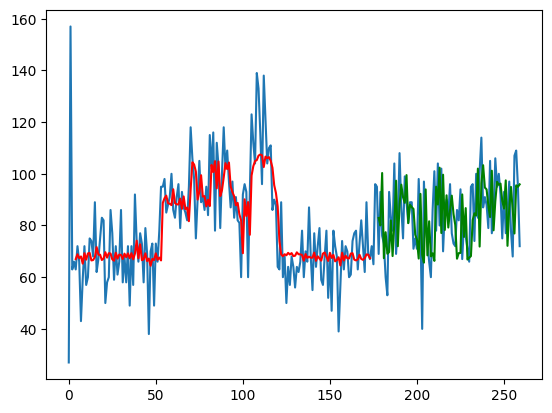

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

df = pd.read_csv('train.csv')
timeseries = df[["Failed_Gadgets"]].values.astype('float32')

# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

In [ ]:
df

,Date,Days_Operating_in a Week,Failed_Gadgets,Gadgets_in_Production
0,1/1/2018,5,27,109890
1,1/8/2018,5,157,109890
2,1/15/2018,5,63,109890
3,1/22/2018,5,66,109890
4,1/29/2018,5,63,110495
...,...,...,...,...
255,11/21/2022,3,68,195824
256,11/28/2022,5,107,195824
257,12/5/2022,5,109,190186
258,12/12/2022,5,95,190186


In [ ]:
y_pred